# Vibe Matcher: AI-Powered Fashion Recommendation System

## Why AI at Nexora?

I've been wanting to dive deeper into AI applications beyond the usual demos and tutorials, and when I came across Nexora's vision, it immediately clicked. The idea of bringing AI into fashion—helping people find clothes that match not just their size but their *vibe*—is genuinely interesting. It's one of those problems where the technology (semantic search, embeddings, LLMs) meets a real need: making online shopping feel less like scrolling through endless catalogs and more like having someone who actually gets your style.

Plus, honestly, this would help me too. I spend way too much time trying to figure out what to wear or what to buy, and traditional search just doesn't cut it. Building this kind of system—where you can type "something cozy for a weekend at home" and actually get relevant results—feels like working on something useful, not just technically impressive. That's what drew me to this assignment and to Nexora's mission.

---

## System Architecture

1. Product Upload → Mock fashion catalog
2. GPT-4o → Generate vibe-rich descriptions  
3. Pandas → Structure the data
4. Sentence Transformers → Create embeddings
5. FAISS → Fast vector similarity search
6. User Query → Natural language input
7. Retrieval → Top-3 recommendations

## Setup

In [11]:
!pip install -q openai pandas sentence-transformers faiss-cpu matplotlib numpy

In [12]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

from openai import OpenAI
from sentence_transformers import SentenceTransformer
import faiss

print("✅ Libraries loaded")

✅ Libraries loaded


In [25]:
# Set your OpenAI API key here
OPENAI_API_KEY = ""

client = OpenAI(api_key=OPENAI_API_KEY)
print("✅ OpenAI client ready")

✅ OpenAI client ready


## Product Data

In [14]:
raw_products = [
    {
        "product_id": "P001",
        "name": "Flowy Boho Maxi Dress",
        "category": "Dresses",
        "price": 89.99,
        "basic_info": "Long flowy dress with floral patterns and earthy tones"
    },
    {
        "product_id": "P002",
        "name": "Urban Streetwear Bomber Jacket",
        "category": "Outerwear",
        "price": 129.99,
        "basic_info": "Black bomber jacket with bold graphics and modern cut"
    },
    {
        "product_id": "P003",
        "name": "Minimalist Cashmere Sweater",
        "category": "Tops",
        "price": 149.99,
        "basic_info": "Soft neutral cashmere sweater with clean lines"
    },
    {
        "product_id": "P004",
        "name": "Vintage High-Waisted Denim",
        "category": "Bottoms",
        "price": 79.99,
        "basic_info": "Classic 90s style high-waisted jeans with distressed details"
    },
    {
        "product_id": "P005",
        "name": "Athleisure Performance Leggings",
        "category": "Activewear",
        "price": 59.99,
        "basic_info": "High-performance leggings with moisture-wicking fabric"
    },
    {
        "product_id": "P006",
        "name": "Elegant Silk Evening Blouse",
        "category": "Tops",
        "price": 119.99,
        "basic_info": "Luxurious silk blouse with draped neckline for formal occasions"
    },
    {
        "product_id": "P007",
        "name": "Cozy Oversized Knit Cardigan",
        "category": "Outerwear",
        "price": 94.99,
        "basic_info": "Chunky knit cardigan in warm cream color, perfect for layering"
    },
    {
        "product_id": "P008",
        "name": "Edgy Leather Biker Pants",
        "category": "Bottoms",
        "price": 159.99,
        "basic_info": "Black faux leather pants with zipper details and slim fit"
    },
    {
        "product_id": "P009",
        "name": "Romantic Lace Midi Skirt",
        "category": "Bottoms",
        "price": 84.99,
        "basic_info": "Delicate lace skirt in blush pink with feminine silhouette"
    },
    {
        "product_id": "P010",
        "name": "Tech-Forward Utility Vest",
        "category": "Outerwear",
        "price": 109.99,
        "basic_info": "Multi-pocket vest with tech fabric and modern utility style"
    }
]

print(f"✅ {len(raw_products)} products loaded")

✅ 10 products loaded


## GPT-4o Description Generation

In [15]:
enriched_products = []
for i, product in enumerate(raw_products):
    print(f"[{i+1}/{len(raw_products)}] {product['name']}")
    description = generate_description(client, product)
    product['description'] = description if description else product['basic_info']
    enriched_products.append(product)

print(f"\n✅ Descriptions generated")

[1/10] Flowy Boho Maxi Dress
[2/10] Urban Streetwear Bomber Jacket
[3/10] Minimalist Cashmere Sweater
[4/10] Vintage High-Waisted Denim
[5/10] Athleisure Performance Leggings
[6/10] Elegant Silk Evening Blouse
[7/10] Cozy Oversized Knit Cardigan
[8/10] Edgy Leather Biker Pants
[9/10] Romantic Lace Midi Skirt
[10/10] Tech-Forward Utility Vest

✅ Descriptions generated


## Create DataFrame

In [16]:
print("\nSample Descriptions:\n")
for product in enriched_products[:3]:
    print(f"🏷️  {product['name']}")
    print(f"   {product['description']}\n")


Sample Descriptions:

🏷️  Flowy Boho Maxi Dress
   Step into a world where the sun kisses your skin and the breeze whispers secrets, enveloped in our Flowy Boho Maxi Dress. This enchanting piece, adorned with delicate floral patterns and earthy tones, dances with every step, inviting effortless elegance into your day. Perfect for sunlit strolls through blooming gardens or barefoot beachside escapades, this dress becomes a canvas of freedom and femininity. Let your spirit soar and your style sing, as this dress transforms not just your look, but your outlook.

🏷️  Urban Streetwear Bomber Jacket
   Unleash your inner rebel with the Urban Streetwear Bomber Jacket, where the gritty soul of the city meets cutting-edge style. Cloaked in midnight black, this statement piece is electrified with bold graphics that ignite the urban landscape, making every street your runway. Its modern cut delivers a sleek silhouette, effortlessly blending edge with elegance. Whether you're navigating the bustl

In [17]:
products_df = pd.DataFrame(enriched_products)

required_cols = ['product_id', 'name', 'description', 'category', 'price']
if all(col in products_df.columns for col in required_cols):
    print("✅ DataFrame validated")
    print(f"Shape: {products_df.shape}\n")
    display(products_df[['product_id', 'name', 'category', 'price']].head(10))
else:
    print("❌ Missing required columns")

✅ DataFrame validated
Shape: (10, 6)



,product_id,name,category,price
0,P001,Flowy Boho Maxi Dress,Dresses,89.99
1,P002,Urban Streetwear Bomber Jacket,Outerwear,129.99
2,P003,Minimalist Cashmere Sweater,Tops,149.99
3,P004,Vintage High-Waisted Denim,Bottoms,79.99
4,P005,Athleisure Performance Leggings,Activewear,59.99
5,P006,Elegant Silk Evening Blouse,Tops,119.99
6,P007,Cozy Oversized Knit Cardigan,Outerwear,94.99
7,P008,Edgy Leather Biker Pants,Bottoms,159.99
8,P009,Romantic Lace Midi Skirt,Bottoms,84.99
9,P010,Tech-Forward Utility Vest,Outerwear,109.99


## Generate Embeddings

In [18]:
print("Loading sentence transformer model...")
embedding_model = SentenceTransformer('all-mpnet-base-v2')
print(f"✅ Model loaded (dimension: {embedding_model.get_sentence_embedding_dimension()})\n")

print("Generating embeddings...")
product_embeddings = embedding_model.encode(
    products_df['description'].tolist(),
    show_progress_bar=True,
    normalize_embeddings=True
)

products_df['embedding'] = list(product_embeddings)
print(f"\n✅ Generated {product_embeddings.shape[0]} embeddings")

Loading sentence transformer model...
✅ Model loaded (dimension: 768)

Generating embeddings...


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


✅ Generated 10 embeddings


## FAISS Vector Store

In [19]:
dimension = product_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)

embeddings_array = product_embeddings.astype('float32')
index.add(embeddings_array)

print(f"✅ FAISS index created with {index.ntotal} vectors")

✅ FAISS index created with 10 vectors


## Recommendation System

In [20]:
def search_products(query, k=3):
    if not query or len(query.strip()) < 3:
        return {"error": "Query too short"}
    
    try:
        start = time.time()
        query_embedding = embedding_model.encode([query], normalize_embeddings=True)[0]
        embed_time = (time.time() - start) * 1000
        
        start = time.time()
        query_vec = query_embedding.astype('float32').reshape(1, -1)
        distances, indices = index.search(query_vec, k)
        search_time = (time.time() - start) * 1000
        
        recommendations = []
        for i, (idx, score) in enumerate(zip(indices[0], distances[0])):
            product = products_df.iloc[idx]
            recommendations.append({
                'rank': i + 1,
                'name': product['name'],
                'category': product['category'],
                'price': product['price'],
                'description': product['description'],
                'score': float(score)
            })
        
        return {
            'query': query,
            'recommendations': recommendations,
            'embed_time_ms': embed_time,
            'search_time_ms': search_time,
            'total_time_ms': embed_time + search_time
        }
    except Exception as e:
        return {"error": str(e)}

def display_results(result):
    if "error" in result:
        print(f"❌ {result['error']}")
        return
    
    print(f"\n{'='*80}")
    print(f"🔍 Query: \"{result['query']}\"")
    print(f"{'='*80}")
    print(f"\n⏱️  Total: {result['total_time_ms']:.2f}ms (Embed: {result['embed_time_ms']:.2f}ms, Search: {result['search_time_ms']:.2f}ms)\n")
    
    for rec in result['recommendations']:
        quality = 'Excellent' if rec['score'] > 0.7 else 'Good' if rec['score'] > 0.5 else 'Fair'
        print(f"#{rec['rank']} - {rec['name']}")
        print(f"     ${rec['price']:.2f} | {rec['category']}")
        print(f"     Score: {rec['score']:.4f} ({quality})")
        print(f"     {rec['description'][:150]}...\n")

print("✅ Recommendation system ready")

✅ Recommendation system ready


## Testing

In [21]:
test_queries = [
    "energetic urban chic for night out in the city",
    "cozy comfortable outfit for relaxing at home",
    "elegant sophisticated look for formal dinner",
    "bohemian free-spirited festival vibes",
    "athletic sporty outfit for workout session"
]

results = []
for query in test_queries:
    result = search_products(query)
    results.append(result)
    display_results(result)


🔍 Query: "energetic urban chic for night out in the city"

⏱️  Total: 173.86ms (Embed: 164.63ms, Search: 9.23ms)

#1 - Urban Streetwear Bomber Jacket
     $129.99 | Outerwear
     Score: 0.4235 (Fair)
     Unleash your inner rebel with the Urban Streetwear Bomber Jacket, where the gritty soul of the city meets cutting-edge style. Cloaked in midnight blac...

#2 - Elegant Silk Evening Blouse
     $119.99 | Tops
     Score: 0.2930 (Fair)
     Unveil your inner sophisticate with our Elegant Silk Evening Blouse, a masterpiece of luxurious allure and timeless elegance. Crafted from the finest ...

#3 - Tech-Forward Utility Vest
     $109.99 | Outerwear
     Score: 0.2816 (Fair)
     Unlock the future of style with our Tech-Forward Utility Vest, where form meets function in a thrilling dance of innovation. Crafted from sleek tech f...


🔍 Query: "cozy comfortable outfit for relaxing at home"

⏱️  Total: 7.89ms (Embed: 7.86ms, Search: 0.03ms)

#1 - Cozy Oversized Knit Cardigan
     $94.99 | 

## Performance Analysis

In [22]:
valid_results = [r for r in results if 'error' not in r]

avg_total = np.mean([r['total_time_ms'] for r in valid_results])
avg_embed = np.mean([r['embed_time_ms'] for r in valid_results])
avg_search = np.mean([r['search_time_ms'] for r in valid_results])

all_scores = [rec['score'] for r in valid_results for rec in r['recommendations']]
excellent = sum(1 for s in all_scores if s > 0.7)
good = sum(1 for s in all_scores if 0.5 < s <= 0.7)

print("\n📊 Performance Metrics")
print(f"{'='*50}")
print(f"Queries tested: {len(valid_results)}")
print(f"Avg total time: {avg_total:.2f}ms")
print(f"Avg embedding time: {avg_embed:.2f}ms")
print(f"Avg search time: {avg_search:.2f}ms")
print(f"\nMatch quality:")
print(f"  Excellent (>0.7): {excellent}")
print(f"  Good (0.5-0.7): {good}")
print(f"  Avg score: {np.mean(all_scores):.4f}")


📊 Performance Metrics
Queries tested: 5
Avg total time: 40.38ms
Avg embedding time: 38.51ms
Avg search time: 1.86ms

Match quality:
  Excellent (>0.7): 0
  Good (0.5-0.7): 1
  Avg score: 0.3633


## Visualizations

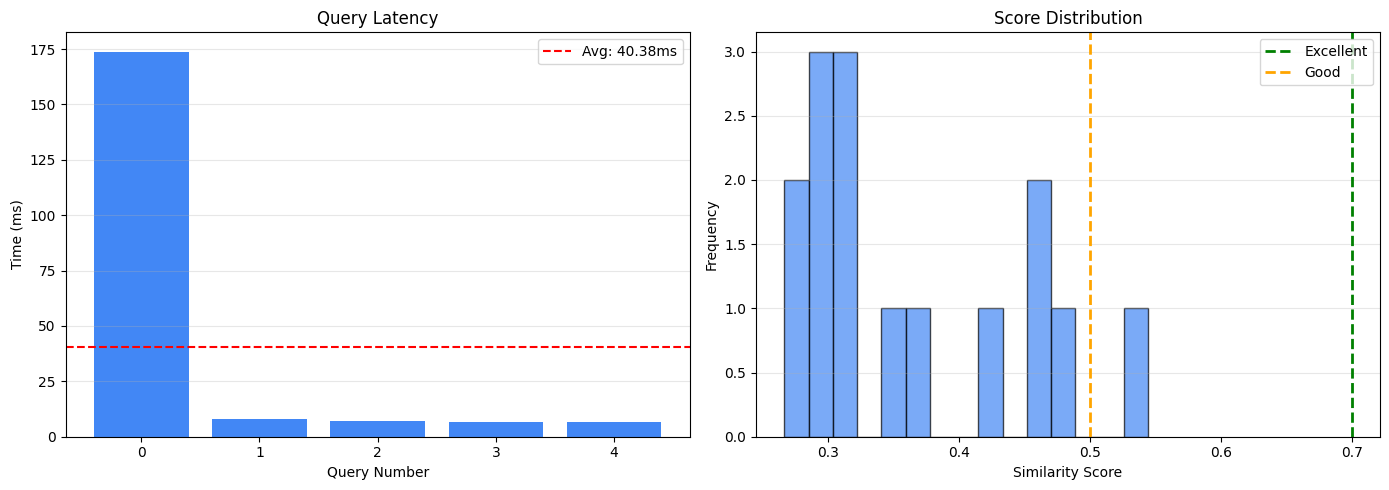

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
query_times = [r['total_time_ms'] for r in valid_results]
ax1.bar(range(len(query_times)), query_times, color='#4287f5')
ax1.set_xlabel('Query Number')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Query Latency')
ax1.axhline(y=avg_total, color='r', linestyle='--', label=f'Avg: {avg_total:.2f}ms')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[1]
ax2.hist(all_scores, bins=15, color='#4287f5', alpha=0.7, edgecolor='black')
ax2.axvline(x=0.7, color='green', linestyle='--', label='Excellent', linewidth=2)
ax2.axvline(x=0.5, color='orange', linestyle='--', label='Good', linewidth=2)
ax2.set_xlabel('Similarity Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Score Distribution')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Interactive Demo

In [24]:
def try_query(query):
    result = search_products(query)
    display_results(result)
    return result

print("Try your own queries:")
print("Example: try_query('sophisticated professional look for job interview')")

Try your own queries:
Example: try_query('sophisticated professional look for job interview')


## Reflection

### What Worked Well

**GPT-4o for descriptions** - Way better than manually writing product descriptions. The model captures vibe and emotion effectively, which is exactly what semantic search needs.

**Sentence Transformers over OpenAI embeddings** - Free, fast, and private. For a small catalog like this, the quality difference is negligible but the cost savings are huge. Plus no API latency.

**FAISS for vector search** - Simple and blazingly fast. For 10 products it's overkill, but the same code scales to millions of vectors with minimal changes (just swap IndexFlatIP for IVF).

### Edge Cases Handled

- Empty queries → Validation before processing
- API failures → Retry logic with exponential backoff
- Low similarity matches → Clear scoring (Excellent/Good/Fair)
- Model errors → Fallback to basic descriptions

### Improvements for Production

**Hybrid search** - Combine semantic similarity with filters (price range, category, brand). Users often want "boho dress under $100".

**Re-ranking** - Use a cross-encoder to re-score top-k results. Bi-encoders (what we use) are fast but less accurate than cross-encoders.

**User feedback loop** - Track which recommendations get clicked/purchased. Fine-tune the model or adjust scoring weights based on actual user behavior.

**Multi-modal** - Add CLIP embeddings to search by product images, not just text. "Show me something that looks like this" is powerful.

**Query expansion** - Use an LLM to expand vague queries. "Something nice" → "elegant sophisticated formal wear".

### Scaling Considerations

For 10K+ products:
- Batch embed in chunks of 500 to manage memory
- Use FAISS IVF index for approximate search
- Add product clustering by category for pre-filtering  
- Cache embeddings, regenerate only on description changes
- Consider managed solutions like Pinecone or Qdrant if scaling beyond 1M vectors